## A notebook solving the SemEval 2019 suggestion mining challenge.

### Introduction

NLP has had its ImageNet moment in the advent of Transfer learning frameworks like BERT and embeddings like GLOVE, Universal Sentences Encoding, Fasttext vectors etc. 
The present problem of suggestion mining will be solved using the following approaches demostrating these techniques: 

0. Baseline using Fasttext classification
1. Using GLOVE for traditional embeddings.
GLOVE vectors are trained using CBOW(Continuous Bag of Words) or ngram, take only context in one direction.
2. Pre-Trained Word embeddings using BERT for classification.
BERT is trained Bidirectionally using a Transformer architechture, thus utilizing both contexts.
3. Domain FineTuning of BERT embeddings for classification.
Domain Finetuning helps to update the embeddings according to the domain, improving classification predictions.
4. Classification using Gradient boosted trees and Neural Nets.

In [1]:
import nltk
import re
import pickle
import numpy as np
import pandas as pd
import gc

from gensim.models import KeyedVectors
import time, os

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from tqdm import tqdm

import fasttext as ft

import lightgbm as lgb
from bert_serving.client import BertClient

from keras.layers import Dense, Input, Bidirectional, Activation, Conv1D, GRU, Lambda, LSTM
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalAveragePooling1D,MaxPooling1D,GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.layers import Dropout,Embedding,Add,Flatten
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import Callback,EarlyStopping,ModelCheckpoint
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.layers.merge import concatenate

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Using TensorFlow backend.


In [2]:
#SPELL CHECKER - disabled due to lack of improvement

# from symspellpy.symspellpy import SymSpell

# max_edit_distance_dictionary = 2
# prefix_length = 7
# sym_spell = SymSpell(max_edit_distance_dictionary, prefix_length)

# dictionary_path = "./spell_check_dictionary.txt"
# term_index = 0
# count_index = 1

# if not sym_spell.load_dictionary(dictionary_path, term_index, count_index):
#     print('no spell dict')
# print('spell check model loaded')

In [3]:
# Data Paths
train_data='./data/train.csv'
val_data='./data/val_lab.csv'
test_data='./data/test.csv'

In [4]:
# Importing the data into pandas dataframe.  
train_df = pd.read_csv(train_data, names = ["id", "sentence", "label"], encoding = "ISO-8859-1")
val_df = pd.read_csv(val_data, encoding = "ISO-8859-1" )
test_df = pd.read_csv(test_data, names = ["id", "sentence", "label"], encoding = "ISO-8859-1" )

## Data Exploration

In [5]:
train_df['sentence'].head()

0    "Please enable removing language code from the...
1    "Note: in your .csproj file, there is a Suppor...
2    "Wich means the new version not fully replaced...
3    "Some of my users will still receive the old x...
4    "The store randomly gives the old xap or the n...
Name: sentence, dtype: object

In [6]:
train_df['label'].value_counts()

0    6415
1    2085
Name: label, dtype: int64

Class Imbalance exists. Can be rectified by Oversampling - Using SMOTE, in order to randomly sample k nearest neighbors. 
First lets clean the data to make it easier to get consistent embeddings.

## Complete Data Cleaning

In [7]:
## A spelling correction function, maybe used in the future, could not yield increase in accuracy

# def spell_check(text):
#     try:
#         max_edit_distance_lookup = 2
#         suggestions = sym_spell.lookup_compound(text, max_edit_distance_lookup)

#         for suggestion in suggestions:
#             return(suggestion.term)
        
#     except Exception as e:
#         return

## Replacing key abbreviations/slang and bigrams

def rep(sent):
    sent = sent.replace(' u ', " you ").replace(' im ', ' i am ') \
    .replace(' r ', " are ").replace(' u ', ' you ').replace('plz','please').replace(' pc ',' computer ') \
    .replace('i\'m','i am').replace("'s",'is').replace("'t",'not').replace("'d",'would').replace(' e g ',' example') \
    .replace("doesn t",'does not').replace("e.g",'example') \
    .replace("i.e.","that is").replace('wich','which')
    
#     sent = spell_check(sent)
    sent = " ".join(sent.split())
    return sent

## Main preprocessing function
def preprocess(x):
    
    # Preprocess URLS
    x.loc[:,"sentence"] = x.sentence.apply(lambda x : re.sub(r'http\S+', '', x) )
    
    # Lower Case all string to help increase uniformity in embedding creation
    x.loc[:,"sentence"] = x.sentence.apply(lambda x : str.lower(x))

    #Remove numbers, special characters
    x.loc[:,"sentence"] = x.sentence.apply(lambda x : (re.sub(r'([^a-zA-Z ]+?)', '', x)))

    # Replace abbs/other modeifications
    x.loc[:,"sentence"] = x.sentence.apply(lambda x : rep(x))
    
    # Remove empty strings, containing only urls etc.
    x = x[x.sentence != '']
    x = x[x.sentence != ' ']
    
    return x

### Preprocess Training and Validation Data

In [8]:
train_df = preprocess(train_df)
val_df = preprocess(val_df)
test_df = preprocess(test_df)

In [9]:
train_df['sentence'].head()

0    please enable removing language code from the ...
1    note in your csproj file there is a supportedc...
2    which means the new version not fully replaced...
3    some of my users will still receive the old xa...
4    the store randomly gives the old xap or the ne...
Name: sentence, dtype: object

In [10]:
## 0 label counts decreased due to preprocessing
train_df['label'].value_counts()

0    6381
1    2085
Name: label, dtype: int64

# 1) Using BERT embeddings for classification
In this section the first approach; of using bert embeddings(using bert-as-a-service server) is covered.
BERT encoding is performed on the Training, Validation and the Test Set.
Then the training data is split to train the LightGBM model, which is a fast gradient boosting framework.
Its hyperparams are tuned by using Bayesian tuning using skopt.

## Tokenization + Encoding with BERT Embedding - Training Data

In [12]:
bc = BertClient()
X_train=[]
from tqdm import tqdm
for i in tqdm(list(train_df['sentence'])): 
    print([i])
    X_train.append(bc.encode([i]))
y_train = list(train_df['label'])

Utilies for storing and retrieving the embeddings(Since they take a while to be created)

In [12]:
with open('bert_array.pkl', 'wb') as f:
    pickle.dump(X_train, f)

In [13]:
with open('bert_array.pkl', 'rb') as f:
    X_train = pickle.load( f)

Code for flattening the embedding array

In [14]:
X_train_n = []
for sublist in X_train:
    for item in sublist:
        X_train_n.append(item)

### Using SMOTE for class imbalance
1. Simply OverSampling: has disadvantages in information duplication and overfitting
2. Simply UnderSampling: has disadvantages in  information loss.
3. Hence OverSampling using smote based on the data distribution is most useful.

In [15]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12, ratio = 1.0)

In [16]:
X_train_bal, y_train_bal = sm.fit_sample(X_train_n, y_train)

We can see that the number of 0 and 1 label samples have been equalized by number of Y observations

In [17]:
len(y_train_bal)

12762

There is no class imbalance in the Validation set.

In [18]:
# No Imbalance here
val_df['label'].value_counts()

1    296
0    296
Name: label, dtype: int64

## Tokenization + Encoding with BERT Embedding - Validation Data

In [19]:
bc = BertClient()
X_val=[]
from tqdm import tqdm
for i in tqdm(list(val_df['sentence'])): 
    print([i])
    X_val.append(bc.encode([i]))
y_val = list(val_df['label'])

Utilies for saving and retrieving validation BERT embeddings

In [20]:
with open('bert_array_val.pkl', 'wb') as f:
    pickle.dump(X_val, f)

In [20]:
with open('bert_array_val.pkl', 'rb') as f:
    X_val = pickle.load( f)

Flattening the validation set

In [21]:
X_val_n = []
for sublist in X_val:
    for item in sublist:
        X_val_n.append(item)

## Tokenization + Encoding with BERT Embedding - Test Data

In [22]:
bc = BertClient()
X_test=[]
from tqdm import tqdm
for i in tqdm(list(test_df['sentence'])): 
    print([i])
    X_test.append(bc.encode([i]))    

Utilies for saving and retrieving validation BERT embeddings

In [24]:
# with open('bert_array_test.pkl', 'wb') as f:
#     pickle.dump(X_test, f)

In [23]:
with open('bert_array_test.pkl', 'rb') as f:
    X_test = pickle.load( f)

Flattening the validation set

In [24]:
X_test_n = []
for sublist in X_test:
    for item in sublist:
        X_test_n.append(item)

## Training a lightGBM gradient boosting algorithm

In [25]:
# Method for evaluating fi score for lightgbm
def lgb_f1_score(y_preds, data):
    y_train = data.get_label()
    y_preds = (y_preds >= 0.5).astype(int)
    return 'f1_score', f1_score(y_train, y_preds), True

params = {
          'objective':'binary', 
          "boosting": "gbdt",  
          'learning_rate': 0.1, 
          'max_depth': -1, 
          "feature_fraction": 0.8, 
          "bagging_freq": 1, 
          "bagging_fraction": 0.8 , 
          "bagging_seed": 11,
          "lambda_l1": 0.1, 
          'num_leaves': 60, 
          'min_data_in_leaf': 60, 
          "verbosity": -1, 
          "random_state": 3
         }

# Shuffling Data
shuffle_indices = np.random.permutation(np.arange(len(y_train_bal)))
X_train_bal=np.array(X_train_bal)
y_train_bal=np.array(y_train_bal)
    
X_train_bal_shuffled = X_train_bal[shuffle_indices]
y_train_bal_shuffled = y_train_bal[shuffle_indices]

# Splitting training data into Training and Validation
val_idx = max(1, int(len(y_train_bal_shuffled) * 0.2))
train_data_split, val_data_split = X_train_bal_shuffled[:-val_idx], X_train_bal_shuffled[-val_idx:]
labels_train, labels_val = y_train_bal_shuffled[:-val_idx], y_train_bal_shuffled[-val_idx:]

# Training model
model = lgb.train(params, lgb.Dataset(train_data_split, labels_train), \
                  2500, lgb.Dataset(val_data_split, labels_val), \
                  feval=lgb_f1_score ,verbose_eval=100, early_stopping_rounds=100)
model.save_model('lgb.model')

print('training...')

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.185929	valid_0's f1_score: 0.93007
[200]	valid_0's binary_logloss: 0.194392	valid_0's f1_score: 0.932816
Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.182664	valid_0's f1_score: 0.930793
training...


In [26]:
lgb_val_pred = model.predict(X_val_n)

lgb_val_pred = (lgb_val_pred >= 0.5).astype(int)
print(f1_score(y_val, lgb_val_pred))
print(classification_report(y_val, lgb_val_pred, target_names=['NS','S']))

0.7654320987654321
              precision    recall  f1-score   support

          NS       0.75      0.82      0.78       296
           S       0.80      0.73      0.77       296

   micro avg       0.78      0.78      0.78       592
   macro avg       0.78      0.78      0.77       592
weighted avg       0.78      0.78      0.77       592



In [27]:
lgb_test_pred = model.predict(X_test_n)
lgb_test_pred = (lgb_test_pred >= 0.5).astype(int)

# 2) Finetuning BERT Transformer to domain
In this approach, I finetuned the BERT pre-trained Uncased 768D embeddings, to the training data. 
Using the BERT script provided in the bert repository `run_classifier.py`, the pretrained model was finetuned to the given domain data. 
This process is called transfer learning, and is relatively inexpensive to perform, in comparison to training the full neural network from scratch. 
The bert validation prediction and test are uploaded alongside the notebook 

This is the evaluation of the validation predictions

In [28]:
bert_val_preds = pd.read_csv('C:/Users/admin/InternshipTask/NLP Task/bert_dev_results.tsv',sep='\t', names=['label0','label1'])

BERT model outputs the probabilies of each class, so we need to create the predictions by taking the label with maximum probabililty.

In [31]:
for ind,row in bert_val_preds.iterrows():
    if row['label0']>row['label1']:
        bert_val_preds['label_pred'][ind] = 0
    else:
        bert_val_preds['label_pred'][ind] = 1

C:\Users\admin\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\admin\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Evaluating the performance. 
BERT with finetuning gives this highest f1 score out of all approaches.

In [32]:
bert_fn_val_pred = list(bert_val_preds['label_pred'])
print(f1_score(y_val, bert_fn_val_pred))
print(classification_report(y_val, bert_fn_val_pred, target_names=['NS','S']))

0.8694214876033058
              precision    recall  f1-score   support

          NS       0.88      0.84      0.86       296
           S       0.85      0.89      0.87       296

   micro avg       0.87      0.87      0.87       592
   macro avg       0.87      0.87      0.87       592
weighted avg       0.87      0.87      0.87       592



Get BERT model test predictions

In [33]:
bert_test_preds = pd.read_csv('C:/Users/admin/InternshipTask/NLP Task/bert_test_results.tsv',sep='\t', names=['label0','label1'])

In [34]:
bert_test_preds['label_pred']=0
for ind,row in bert_test_preds.iterrows():
    if row['label0']>row['label1']:
        bert_test_preds['label_pred'][ind] = 0
    else:
        bert_test_preds['label_pred'][ind] = 1

C:\Users\admin\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\admin\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## 3) GLOVE Approach
Here the GLOVE 100D embeddings were used to train a neural network model.

### Creating training and validation set for Neural Network approach

Steps: 
1. Tokenizing the sentence string
2. Use GLOVE embedding to find word vectors
Any other embedding could also be used such as fastText, Facebooks InferSent, Google's Universal encoder etc. 
GLOve was chosen due to its low weight and ease of use.
Using different embedding mechanisms can have significant effect on the outcome.
3. Train a neural net composed of GRUs, CNNs, and dropout (selected post permutation) 

In [35]:
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [36]:
def create_train_set(df, model, split=0.2, max_seq_len=0):
    
    total_array = list(df['sentence'])
    s1 = list(df['label'])
    
    total_array1 = []
    maxlen =0
    
    for sent in total_array:
        arrayin=[]
        count = 0
        for word in sent.split(' '):
            word = word.replace(' ','')
            try:
                a = model[word]
                arrayin.append(a)
                count+=1
            except Exception as e:
                #print(e) -- for out of dictionary words
                continue
        if count>maxlen:
            maxlen = count
        total_array1.append(arrayin)
    
    # check if train set or val set.
    if max_seq_len == 0:
        max_seq_len=maxlen
    
    total_array = total_array1
    
    # Padding the string sequences
    train_padded_data = pad_sequences(total_array, maxlen=max_seq_len)
    
    train_data=train_padded_data
    train_labels= s1
    
    np.random.seed(42)
    shuffle_indices = np.random.permutation(np.arange(len(train_labels)))
    
    train_data=np.array(train_data)
    train_labels=np.array(train_labels)
    
    train_data_shuffled = train_data[shuffle_indices]
    train_labels_shuffled = train_labels[shuffle_indices]

    val_idx = max(1, int(len(train_labels_shuffled) * split))
    
    train_data_split, val_data_split = train_data_shuffled[:-val_idx], train_data_shuffled[-val_idx:]
    labels_train, labels_val = train_labels_shuffled[:-val_idx], train_labels_shuffled[-val_idx:]
    
    return train_data_split, labels_train, val_data_split, labels_val, max_seq_len

In [37]:
class Model_GRU_CNN:
    
    def __init__(self, embedding_dim, model, lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0):
        self.embedding_dim = embedding_dim
        self.lr = lr
        self.lr_d = lr_d
        self.units = units
        self.dr = dr
        self.model = model
        
    def train_model(self,):
        """
            Steps:
                1. Create training and val data
                3. Pass the  dense layer vectors to sigmoid output layer
                4. Use loss to train weights
        """
        global train_df, val_df 
        train_data, train_labels, val_data, val_labels, self.max_len = create_train_set(train_df, self.model, max_seq_len=0)
        
        sequence_input = Input(shape=(self.max_len,self.embedding_dim,))
        x1 = SpatialDropout1D(self.dr)(sequence_input)

        x = Bidirectional(GRU(self.units, return_sequences = True))(x1)
        x = Conv1D((self.units//2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)

        y = Bidirectional(LSTM(self.units, return_sequences = True))(x1)
        y = Conv1D((self.units//2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(y)

        avg_pool1 = GlobalAveragePooling1D()(x)
        max_pool1 = GlobalMaxPooling1D()(x)

        avg_pool2 = GlobalAveragePooling1D()(y)
        max_pool2 = GlobalMaxPooling1D()(y)

        x = concatenate([avg_pool1, max_pool1, avg_pool2, max_pool2])

        x = Dense(1, activation = "sigmoid")(x)
        
        model = Model(inputs = sequence_input, outputs = x)
        model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = self.lr, decay = self.lr_d), metrics = ["accuracy"])
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3)

        timestamp = 'lstm_%d_%d_%.2f_%.2f' % (self.embedding_dim ,self.lr, self.lr_d, self.dr)

        checkpoint_dir = './checkpoints/' + str(int(time.time())) + '/'

        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        best_model_path = checkpoint_dir + timestamp + '.h5'

        model_checkpoint = ModelCheckpoint(best_model_path, save_best_only=True, save_weights_only=False)

        self.history = model.fit(train_data, train_labels, validation_data = (val_data, val_labels), 
                            verbose = 1,epochs=10, batch_size=128, shuffle=True,
                  callbacks=[early_stopping,model_checkpoint])

        return best_model_path

Training model

In [38]:
model_1 = Model_GRU_CNN(embedding_dim = 100, model = glove_model, lr = 1e-3, lr_d = 0, units = 112, dr = 0.2)
best_model_path = model_1.train_model()
# from keras.models import load_model
# model_1 = load_model(r'C:\Users\admin\InternshipTask\NLP Task\checkpoints\1553572267\lstm_100_0_0.00_0.20.h5')

Train on 6773 samples, validate on 1693 samples
Epoch 1/10
6773/6773 [==============================] - ETA: 11:02 - loss: 0.6272 - acc: 0.77 - ETA: 6:02 - loss: 0.6160 - acc: 0.7578 - ETA: 4:23 - loss: 0.5791 - acc: 0.778 - ETA: 3:31 - loss: 0.5893 - acc: 0.769 - ETA: 2:59 - loss: 0.5947 - acc: 0.764 - ETA: 2:38 - loss: 0.5990 - acc: 0.760 - ETA: 2:23 - loss: 0.5933 - acc: 0.762 - ETA: 2:10 - loss: 0.5941 - acc: 0.761 - ETA: 2:01 - loss: 0.5916 - acc: 0.760 - ETA: 1:52 - loss: 0.5957 - acc: 0.754 - ETA: 1:45 - loss: 0.5940 - acc: 0.752 - ETA: 1:39 - loss: 0.5914 - acc: 0.753 - ETA: 1:34 - loss: 0.5885 - acc: 0.754 - ETA: 1:30 - loss: 0.5853 - acc: 0.757 - ETA: 1:26 - loss: 0.5828 - acc: 0.759 - ETA: 1:22 - loss: 0.5768 - acc: 0.765 - ETA: 1:18 - loss: 0.5803 - acc: 0.760 - ETA: 1:15 - loss: 0.5796 - acc: 0.758 - ETA: 1:12 - loss: 0.5791 - acc: 0.757 - ETA: 1:09 - loss: 0.5798 - acc: 0.755 - ETA: 1:06 - loss: 0.5775 - acc: 0.756 - ETA: 1:03 - loss: 0.5759 - acc: 0.755 - ETA: 1:00 - los

6773/6773 [==============================] - ETA: 1:18 - loss: 0.3337 - acc: 0.851 - ETA: 1:16 - loss: 0.3834 - acc: 0.820 - ETA: 1:14 - loss: 0.3625 - acc: 0.835 - ETA: 1:13 - loss: 0.3627 - acc: 0.841 - ETA: 1:11 - loss: 0.3810 - acc: 0.834 - ETA: 1:10 - loss: 0.3823 - acc: 0.838 - ETA: 1:08 - loss: 0.3803 - acc: 0.841 - ETA: 1:07 - loss: 0.3790 - acc: 0.837 - ETA: 1:05 - loss: 0.3749 - acc: 0.841 - ETA: 1:04 - loss: 0.3707 - acc: 0.842 - ETA: 1:02 - loss: 0.3817 - acc: 0.835 - ETA: 1:01 - loss: 0.3780 - acc: 0.839 - ETA: 59s - loss: 0.3697 - acc: 0.843 - ETA: 58s - loss: 0.3721 - acc: 0.84 - ETA: 56s - loss: 0.3749 - acc: 0.84 - ETA: 55s - loss: 0.3756 - acc: 0.84 - ETA: 54s - loss: 0.3777 - acc: 0.84 - ETA: 52s - loss: 0.3788 - acc: 0.84 - ETA: 51s - loss: 0.3806 - acc: 0.83 - ETA: 49s - loss: 0.3788 - acc: 0.84 - ETA: 47s - loss: 0.3840 - acc: 0.83 - ETA: 46s - loss: 0.3830 - acc: 0.83 - ETA: 44s - loss: 0.3820 - acc: 0.83 - ETA: 43s - loss: 0.3789 - acc: 0.83 - ETA: 41s - loss: 0

6773/6773 [==============================] - ETA: 1:17 - loss: 0.2611 - acc: 0.898 - ETA: 1:18 - loss: 0.2639 - acc: 0.894 - ETA: 1:16 - loss: 0.2809 - acc: 0.885 - ETA: 1:14 - loss: 0.2844 - acc: 0.882 - ETA: 1:12 - loss: 0.2939 - acc: 0.875 - ETA: 1:11 - loss: 0.3025 - acc: 0.869 - ETA: 1:09 - loss: 0.3048 - acc: 0.870 - ETA: 1:08 - loss: 0.3088 - acc: 0.868 - ETA: 1:06 - loss: 0.3081 - acc: 0.871 - ETA: 1:05 - loss: 0.3179 - acc: 0.870 - ETA: 1:03 - loss: 0.3165 - acc: 0.870 - ETA: 1:02 - loss: 0.3184 - acc: 0.867 - ETA: 1:00 - loss: 0.3143 - acc: 0.869 - ETA: 59s - loss: 0.3124 - acc: 0.870 - ETA: 57s - loss: 0.3151 - acc: 0.86 - ETA: 56s - loss: 0.3115 - acc: 0.87 - ETA: 54s - loss: 0.3123 - acc: 0.87 - ETA: 52s - loss: 0.3110 - acc: 0.87 - ETA: 51s - loss: 0.3127 - acc: 0.87 - ETA: 50s - loss: 0.3171 - acc: 0.87 - ETA: 50s - loss: 0.3196 - acc: 0.87 - ETA: 49s - loss: 0.3201 - acc: 0.87 - ETA: 47s - loss: 0.3198 - acc: 0.86 - ETA: 45s - loss: 0.3200 - acc: 0.86 - ETA: 44s - loss:

6773/6773 [==============================] - ETA: 1:32 - loss: 0.3123 - acc: 0.859 - ETA: 1:26 - loss: 0.3208 - acc: 0.859 - ETA: 1:38 - loss: 0.3172 - acc: 0.867 - ETA: 1:48 - loss: 0.3069 - acc: 0.877 - ETA: 1:48 - loss: 0.3103 - acc: 0.867 - ETA: 1:49 - loss: 0.3044 - acc: 0.875 - ETA: 1:48 - loss: 0.2972 - acc: 0.877 - ETA: 1:46 - loss: 0.2996 - acc: 0.875 - ETA: 1:42 - loss: 0.2989 - acc: 0.869 - ETA: 1:38 - loss: 0.3052 - acc: 0.868 - ETA: 1:34 - loss: 0.3064 - acc: 0.866 - ETA: 1:31 - loss: 0.3037 - acc: 0.867 - ETA: 1:28 - loss: 0.3073 - acc: 0.865 - ETA: 1:25 - loss: 0.3107 - acc: 0.864 - ETA: 1:22 - loss: 0.3056 - acc: 0.868 - ETA: 1:20 - loss: 0.2990 - acc: 0.873 - ETA: 1:17 - loss: 0.2949 - acc: 0.876 - ETA: 1:15 - loss: 0.2919 - acc: 0.876 - ETA: 1:13 - loss: 0.2921 - acc: 0.877 - ETA: 1:10 - loss: 0.2953 - acc: 0.876 - ETA: 1:08 - loss: 0.2939 - acc: 0.877 - ETA: 1:05 - loss: 0.2940 - acc: 0.877 - ETA: 1:03 - loss: 0.2934 - acc: 0.877 - ETA: 1:01 - loss: 0.2931 - acc: 0.8

Plotting Statistics

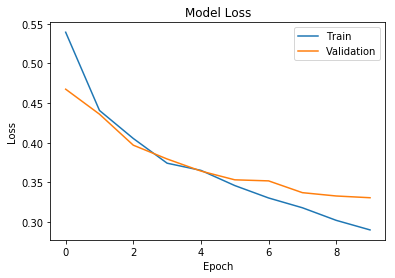

In [44]:
import matplotlib.pyplot as plt
plt.plot(model_1.history.history['loss'])
plt.plot(model_1.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [40]:
def create_test_set(df, model, max_seq_len):
    
    total_array = list(df['sentence'])
    
    total_array1 = []
    for sent in total_array:
        arrayin=[]
        for word in sent.split(' '):
            word = word.replace(' ','')
            try:
                a = model[word]
                arrayin.append(a)
            except Exception as e:
                #print(e) -- for out of dictionary words
                continue
        total_array1.append(arrayin)
    
    total_array = total_array1
    
    # Padding the string sequences
    test_padded_data = pad_sequences(total_array, maxlen=max_seq_len)
    
    test_data=test_padded_data
    test_labels = df['label']
    return test_data, test_labels

In [41]:
test_data, test_label = create_test_set(val_df, glove_model, model_1.max_len)
model = load_model(best_model_path)
y_preds = model.predict(test_data)

Running Validation

In [42]:
y_pred = (y_preds >= 0.5).astype(int)
y_real = test_label
print(f1_score(y_real, y_pred))
print(classification_report(y_real, y_pred, target_names=['NS','S']))

0.6569646569646569
              precision    recall  f1-score   support

          NS       0.66      0.91      0.77       296
           S       0.85      0.53      0.66       296

   micro avg       0.72      0.72      0.72       592
   macro avg       0.76      0.72      0.71       592
weighted avg       0.76      0.72      0.71       592



Running model on test set

In [43]:
test_data, _ = create_test_set(test_df, glove_model, model_1.max_len)
nn_y_preds = model.predict(test_data)
nn_y_pred = (nn_y_preds >= 0.5).astype(int)

## 4) Applying fastText classification for a baseline

In [45]:
train_df.reset_index(drop=True, inplace=True)

Converting Training set to FastText Format

In [46]:
san = train_df['sentence'].copy()
for i in range(len(san)):
    san[i] = '__label__'+str(train_df['label'][i])+' '+san[i]
train_df['sentence'] = san
train_df.head()

,id,sentence,label
0,663_3,__label__1 please enable removing language cod...,1
1,663_4,__label__0 note in your csproj file there is a...,0
2,664_1,__label__0 which means the new version not ful...,0
3,664_2,__label__0 some of my users will still receive...,0
4,664_3,__label__0 the store randomly gives the old xa...,0


In [52]:
fw = open('data/train.txt','w',encoding='utf8')
for i in range(len(train_df)):
    fw.write(train_df['sentence'][i])
    fw.write('\n')
fw.close()

In [47]:
clf = ft.supervised('data/train.txt','data/model')

In [55]:
# fw = open('data/test.txt','w',encoding='utf8')
# for i in range(len(test_df)):
#     fw.write(test_df['sentence'][i])
#     fw.write('\n')
# fw.close()

Running Validation

In [48]:
val_texts = []
for i in range(len(val_df)):
    val_texts.append(val_df['sentence'][i])

pred = clf.predict(val_texts)
val_ft_pred = []
for i in range(len(pred)):
    val_ft_pred.append(int(pred[i][0]))
val_labels = list(val_df['label'])
print(f1_score([int(x) for x in val_labels], val_ft_pred))
print(classification_report([int(x) for x in val_labels], val_ft_pred, target_names=['NS','S']))

0.7023809523809524
              precision    recall  f1-score   support

          NS       0.69      0.90      0.78       296
           S       0.85      0.60      0.70       296

   micro avg       0.75      0.75      0.75       592
   macro avg       0.77      0.75      0.74       592
weighted avg       0.77      0.75      0.74       592



Running model on Test set

In [49]:
test_texts = []
for i in range(len(test_df)):
    test_texts.append(test_df['sentence'][i])

pred = clf.predict(test_texts)
test_ft_pred = []
for i in range(len(pred)):
    test_ft_pred.append(int(pred[i][0]))

# Selecting BERT FineTuned model for submission

In [80]:
sub = pd.DataFrame()
sub['id']=test_df['id']
sub['sentence']=test_df['sentence']
sub['label']=bert_test_preds['label_pred']
sub.head()

,id,sentence,label
0,9566,this would enable live traffic aware apps,0
1,9569,please try other formatting like bold italics ...,1
2,9576,since computers were invented to save time i s...,1
3,9577,allow rearranging if the user wants to change ...,1
4,9579,add simd instructions for better use of arm ne...,1


In [81]:
sub.to_csv('swapnil_parekh.csv', index=False, header=True)

## CREDITS

1. https://github.com/google-research/bert
2. https://github.com/hanxiao/bert-as-service
3. GLOVE vectors